# Hyperparameters space selection

This notebooks contains data exploratory analysis focused on properties that help to establish hyperparameters for selected clustering methods.

In [1]:
from pathlib import Path
from typing import Optional
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from IPython.display import display, Markdown
from pprint import pformat

## Loading data

In [2]:
from utils import load_metabric_data_normed

data, _ = load_metabric_data_normed()

If you installed Somoclu with pip on macOS, this typically means missing a linked library. If you compiled Somoclu with GCC, please make sure you have set DYLD_LIBRARY_PATH to include the GCC path. For more information, please refer to the documentation.


## Basic EDA

In [3]:
data.describe()

,SCGB2A2,MUCL1,SCGB1D2,PIP,LOC648852,DNAJA2,TFF3,S100P,CPB1,CEACAM6,...,DLEU7,LOC641311,LOC645307,IL1RAP,LOC647149,LOC642453,LOC652100,LOC646050,LOC644912,LOC652294
count,2133.000000,2133.000000,2133.000000,2133.000000,2133.000000,2133.000000,2133.000000,2133.000000,2133.000000,2133.000000,...,2133.000000,2133.000000,2133.000000,2133.000000,2133.000000,2133.000000,2133.000000,2133.000000,2133.000000,2133.000000
mean,0.599891,0.435389,0.426811,0.557428,0.401692,0.230142,0.673646,0.463896,0.251524,0.373826,...,0.385145,0.416489,0.472482,0.226373,0.489908,0.355495,0.368785,0.412138,0.329293,0.354874
std,0.302004,0.305368,0.287205,0.293688,0.274286,0.256022,0.250466,0.254031,0.261023,0.244890,...,0.110834,0.103779,0.121520,0.097902,0.131043,0.094577,0.087954,0.129804,0.093695,0.106502
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.332730,0.157567,0.156970,0.308491,0.133838,0.061719,0.557633,0.236734,0.078429,0.153062,...,0.312509,0.349443,0.391301,0.165304,0.404000,0.293491,0.310310,0.330153,0.267596,0.285796
50%,0.662589,0.361126,0.377864,0.605400,0.397042,0.079591,0.744653,0.467523,0.123998,0.338697,...,0.382566,0.411033,0.469143,0.213671,0.489002,0.353014,0.369022,0.408237,0.326025,0.353908
75%,0.885309,0.712268,0.670608,0.817771,0.628504,0.515920,0.864312,0.685032,0.311258,0.569356,...,0.457339,0.478670,0.551078,0.270988,0.579470,0.413061,0.423657,0.490389,0.390386,0.421629
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [4]:
from ydata_profiling import ProfileReport

In [5]:
data_profile = ProfileReport(
    data,
    minimal=True,
)

In [ ]:
data_profile.to_widgets()

## KMeans, KMedoids
* $k$ parameter search space will be selected here

In [34]:
from sklearn.cluster import KMeans, k_means
from sklearn.metrics import silhouette_score
from gap_statistic import OptimalK
from kneefinder import KneeFinder

KMEANS_K_VALUES = np.arange(2, 41, 1)


def tune_plots_kmeans_k(X: pd.DataFrame) -> Optional[KMeans]:
    """
    Method plotting Sum of Sqared Errors (SSE) and Silhouette scores for selected `k` values range.
    Shape of the plots helps to determine if a range of values is sufficient.
    """
    sse = []
    silhouette_scores = []
    for k in tqdm(KMEANS_K_VALUES, leave=False):
        sse.append(KMeans(n_clusters=k, n_init="auto").fit(X).inertia_)
        labels = KMeans(n_clusters=k, n_init="auto").fit_predict(X)
        silhouette_scores.append(silhouette_score(X, labels))

    _, ax = plt.subplots(3, 2, figsize=(10, 15))
    ax = ax.ravel()

    plt.suptitle("KMeans performance")

    ax[0].plot(KMEANS_K_VALUES, sse)
    kf = KneeFinder(KMEANS_K_VALUES, sse)
    knee_x, knee_y = kf.find_knee()
    ax[0].plot([knee_x, knee_x], [min(sse), max(sse)], '--', label=f"Knee at {knee_x, knee_y}")
    ax[0].set_xlabel("k values")
    ax[0].set_ylabel("Sum of Squared Errors")

    ax[1].plot(KMEANS_K_VALUES, silhouette_scores)
    kf = KneeFinder(KMEANS_K_VALUES, silhouette_scores)
    knee_x, knee_y = kf.find_knee()
    ax[1].plot([knee_x, knee_x], [min(silhouette_scores), max(silhouette_scores)], '--', label=f"Knee at {knee_x, knee_y}")
    ax[1].set_xlabel("k values")
    ax[1].set_ylabel("Silhouette score")

    optimal_k = OptimalK(n_jobs=-1, parallel_backend="joblib", n_iter=20, clusterer_kwargs=dict(iter=1, minit="++"))
    _ = optimal_k(data, cluster_array=KMEANS_K_VALUES)

    ax[2].plot(optimal_k.gap_df.n_clusters, optimal_k.gap_df.gap_value)
    max_gap = optimal_k.gap_df.gap_value.max()
    max_gap_ind = optimal_k.gap_df.gap_value.argmax()
    max_gap_n = optimal_k.gap_df.n_clusters[max_gap_ind]
    ax[2].plot(max_gap_n, max_gap, "o")
    ax[2].annotate(
        int(max_gap_n),
        (max_gap_n, max_gap),
        (max_gap_n - 2, max_gap + 0.005),
    )
    ax[2].set_xlabel("k values")
    ax[2].set_ylabel("Gap statistic")

    ax[3].plot(optimal_k.gap_df.n_clusters, optimal_k.gap_df.loc[:, "gap*"])
    max_gap = optimal_k.gap_df.loc[:, "gap*"].max()
    max_gap_ind = optimal_k.gap_df.loc[:, "gap*"].argmax()
    max_gap_n = optimal_k.gap_df.n_clusters[max_gap_ind]
    ax[3].plot(max_gap_n, max_gap, "o")
    ax[3].annotate(
        int(max_gap_n),
        (max_gap_n, max_gap),
        (max_gap_n - 2, max_gap + 0.005),
    )
    ax[3].set_xlabel("k values")
    ax[3].set_ylabel("Gap* statistic")

    ax[4].plot(optimal_k.gap_df.n_clusters, optimal_k.gap_df.loc[:, "diff"])
    pos_diff_ind = optimal_k.gap_df.loc[:, "diff"] > 0
    pos_diff = optimal_k.gap_df.loc[:, "diff"]
    pos_diff_n = optimal_k.gap_df.n_clusters[pos_diff_ind]
    for d, n in zip(pos_diff, pos_diff_n):
        ax[4].scatter(n, d, marker="o")
        ax[4].annotate(
            int(n),
            (n, d),
            (n + 2, d + 0.005),
        )
    ax[4].set_xlabel("k values")
    ax[4].set_ylabel("diff = Gap(k) - Gap(k+1) + s(k+1)")

    ax[5].plot(optimal_k.gap_df.n_clusters, optimal_k.gap_df.loc[:, "diff*"])
    pos_diff_ind = optimal_k.gap_df.loc[:, "diff*"] > 0
    pos_diff = optimal_k.gap_df.loc[pos_diff_ind, "diff*"]
    pos_diff_n = optimal_k.gap_df.n_clusters[pos_diff_ind]
    for d, n in zip(pos_diff, pos_diff_n):
        ax[5].scatter(n, d, marker="o")
        ax[5].annotate(
            int(n),
            (n, d),
            (n + 2, d + 0.005),
        )
    ax[5].set_xlabel("k values")
    ax[5].set_ylabel("diff* = Gap*(k) - Gap*(k+1) + s*(k+1)")

    plt.tight_layout()
    plt.show()

    display(optimal_k.gap_df)


  0%|          | 0/39 [00:00<?, ?it/s]

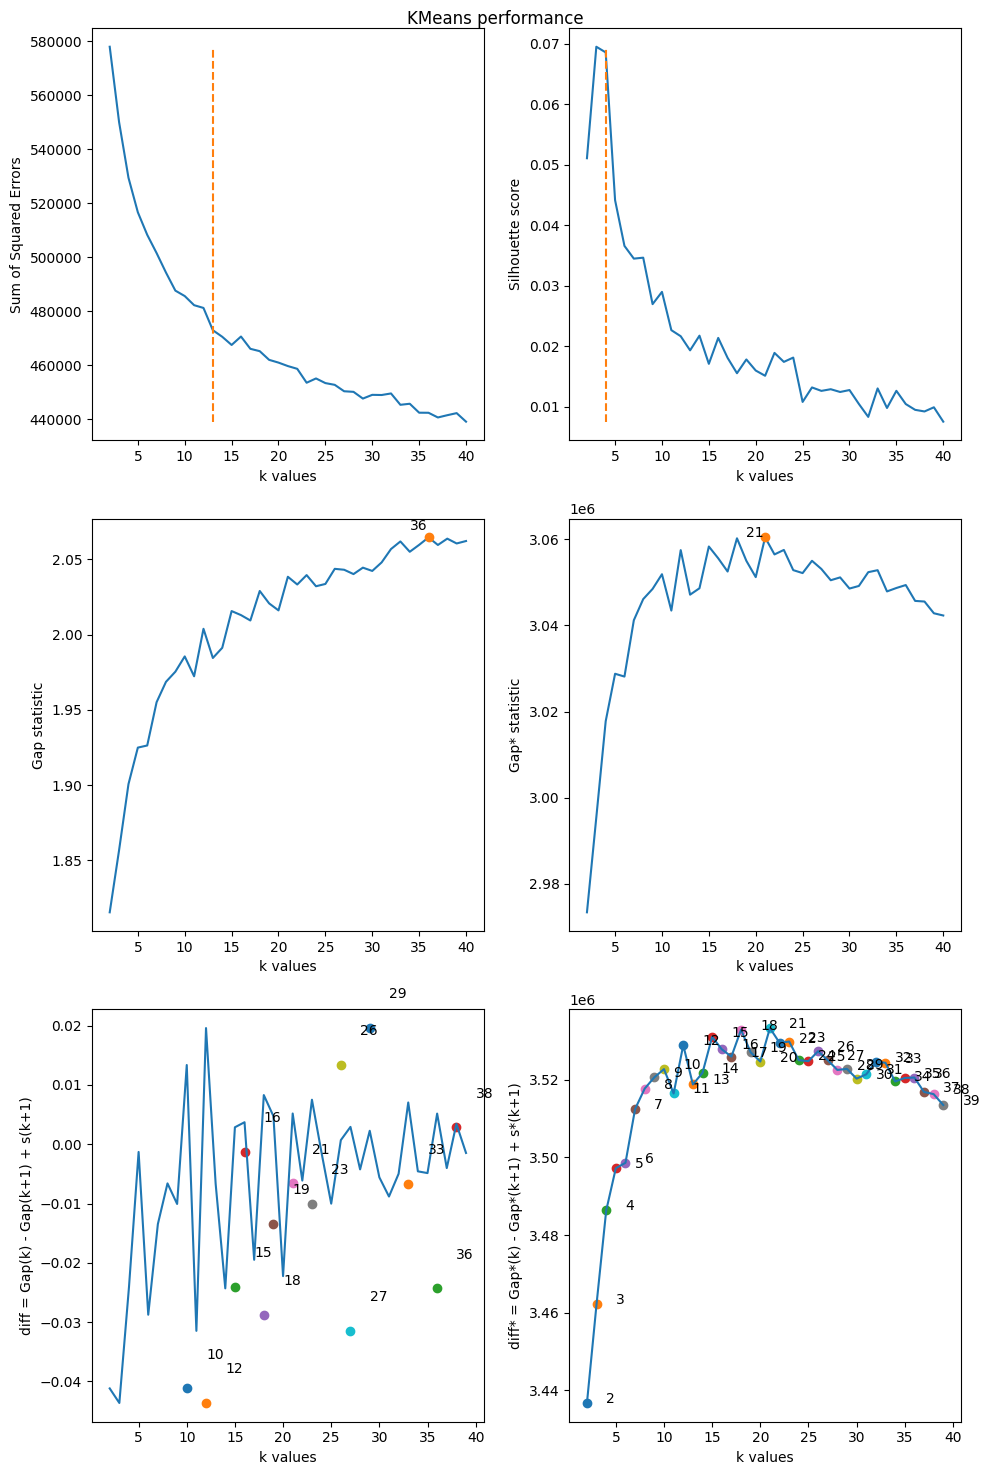

,n_clusters,gap_value,ref_dispersion_std,sk,gap*,sk*,diff,diff*
0,2.0,1.815497,927.839210,0.000302,2.973361e+06,3.433342e+06,-0.041175,3.436761e+06
1,3.0,1.856846,537.923390,0.000175,2.995461e+06,3.458861e+06,-0.043629,3.462312e+06
2,4.0,1.900656,556.791131,0.000181,3.017771e+06,3.484622e+06,-0.024087,3.486325e+06
3,5.0,1.924912,517.147785,0.000168,3.028780e+06,3.497334e+06,-0.001304,3.497234e+06
4,6.0,1.926324,332.202829,0.000108,3.028129e+06,3.496583e+06,-0.028749,3.498607e+06
5,7.0,1.955089,51.425478,0.000017,3.041216e+06,3.511694e+06,-0.013463,3.512453e+06
6,8.0,1.968613,186.598166,0.000061,3.046122e+06,3.517359e+06,-0.006605,3.517726e+06
7,9.0,1.975331,344.576976,0.000112,3.048494e+06,3.520097e+06,-0.010074,3.520625e+06
8,10.0,1.985498,283.699874,0.000093,3.051905e+06,3.524037e+06,0.013354,3.522730e+06
9,11.0,1.972292,452.729367,0.000148,3.043459e+06,3.514283e+06,-0.031468,3.516457e+06


In [35]:
tune_plots_kmeans_k(data)

In [40]:
KMEANS_K_VALUES = np.arange(2, 22, 1)
display(Markdown(f"\n```python\nKMEANS_K_VALUES = {pformat(list(KMEANS_K_VALUES))}\n```"))


```python
KMEANS_K_VALUES = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]
```

## BIRCH
Parameters to evaluate:
* `threshold` - the upper limit of subcluster's radius. 10 values from the range between minimum and maximum distance between samples will be selected.
* `branching_factor` - maximum number of CF Tree node's sublclusters. This will be simply 5 values sampled from the range `[5, 100)`.
* `n_clusters` - _this will be based on the range selected for KMeans algorithm_

In [8]:
from sklearn.metrics.pairwise import euclidean_distances
dist_matrix = euclidean_distances(data)
min_dist = dist_matrix.min()
max_dist = dist_matrix.max()
display(Markdown(f"For `threshold` 10 values from range `({min_dist}, {max_dist})` will be selected."))

For `threshold` 10 values from range `(0.0, 51.144371200065656)` will be selected.

In [9]:
BIRCH_THRESHOLD_VALUES = np.linspace(min_dist, max_dist, num=11)[1:]
display(Markdown(f"\n```python\nBIRCH_THRESHOLD_VALUES = {pformat(list(BIRCH_THRESHOLD_VALUES)+[None])}\n```"))


```python
BIRCH_THRESHOLD_VALUES = [5.114437120006565,
 10.22887424001313,
 15.343311360019696,
 20.45774848002626,
 25.572185600032824,
 30.68662272003939,
 35.80105984004596,
 40.91549696005252,
 46.029934080059085,
 51.144371200065656,
 None]
```

In [10]:
BIRCH_BRANCHING_FACTOR_VALUES = np.linspace(5, 100, num=5, dtype=int)
display(Markdown(f"\n```python\nBIRCH_BRANCHING_FACTOR_VALUES = {pformat(list(BIRCH_BRANCHING_FACTOR_VALUES))}\n```"))


```python
BIRCH_BRANCHING_FACTOR_VALUES = [5, 28, 52, 76, 100]
```

## Affinity propagation
Parameters to evaluate:
* `damping` - extent to which the current value is maintained relative to incoming values (from range `[0.5, 1)`, so 5 values will be sampled from this range)
* `preference` - preference of points, it influences number of exemplars (so also clusters), that will be chosen. Default value is a median of input similarities. Therefore, additionally to median, 10 values from the range selected on this median value will be chosen.

In [11]:
AFFINITY_PROP_DUMPING_VALUES = np.arange(0.5, 1, 0.1)
display(Markdown(f"\n```python\nAFFINITY_PROP_DUMPING_VALUES = {pformat(list(AFFINITY_PROP_DUMPING_VALUES))}\n```"))


```python
AFFINITY_PROP_DUMPING_VALUES = [0.5, 0.6, 0.7, 0.7999999999999999, 0.8999999999999999]
```

In [12]:
from sklearn.metrics import pairwise_distances
similarity_matrix = -pairwise_distances(data, metric="sqeuclidean")
display(Markdown(f"Median of similarities (default `preference` value): {np.median(similarity_matrix)}"))

Median of similarities (default `preference` value): -538.2268609176415

In [13]:
AFFINITY_PROP_PREFERENCE_VALUES = np.linspace(2*np.median(similarity_matrix), 0, num=10)
display(Markdown(f"\n```python\nAFFINITY_PROP_PREFERENCE_VALUES = {pformat(list(AFFINITY_PROP_PREFERENCE_VALUES))}\n```"))


```python
AFFINITY_PROP_PREFERENCE_VALUES = [-1076.453721835283,
 -956.8477527424737,
 -837.2417836496645,
 -717.6358145568554,
 -598.029845464046,
 -478.42387637123693,
 -358.8179072784277,
 -239.21193818561846,
 -119.60596909280923,
 0.0]
```

## DBSCAN
Pameters to evaluate:
* `eps` - the radius of sample's neighborhood
* `min_samples` - minimum number of neighboring samples of a particular sample to consider it a _core point_

Starting poinst for exploration will be determined using approach described in the paper:
```
@inproceedings{rahmah2016determination,
  title={Determination of optimal epsilon (eps) value on dbscan algorithm to clustering data on peatland hotspots in sumatra},
  author={Rahmah, Nadia and Sitanggang, Imas Sukaesih},
  booktitle={IOP conference series: earth and environmental science},
  volume={31},
  number={1},
  pages={012012},
  year={2016},
  organization={IoP Publishing}
}
```

For `min_samples` estimations popular rules of thumb are `num_features+1` or `num_features*2`, however in case of genomic data it is imposible to apply, due to much higher number of dimensions than samples. Therefore a `min_samples` will be gridsearched from range `[5, num_samples/4)`. Ten values will be uniformly selected from this range and for each value a proper epsilon value will be selected.

In [36]:
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors


MIN_SAMPLES_VALUES = np.linspace(5, data.shape[0]/4, num=10, dtype=int)

def tune_dbscan(X: pd.DataFrame, min_samples: int, ax: Optional[plt.Axes]=None) -> Optional[DBSCAN]:
    # tune epsilon with estimation based on NN
    k = min_samples - 1
    nns = NearestNeighbors(n_neighbors=k).fit(X)
    distances, _ = nns.kneighbors(X)
    distances = np.sort(distances, axis=0)
    distances = distances[:, k - 1]

    ax = ax if ax is not None else plt.gca()
    ax.plot(distances)
    kf = KneeFinder(range(0, len(distances)), distances)
    knee_x, knee_y = kf.find_knee()
    ax.plot([0, len(distances)], [knee_y, knee_y], '--', label=f"Knee at {knee_x, knee_y}")
    ax.set_title(f"Distance Curve (of KNN) for {min_samples}")
    ax.set_ylabel("Distance threshold (epsilon)")
    ax.legend()
    return knee_y # found eps value

In [37]:
MIN_SAMPLES_VALUES
display(Markdown(f"\n```python\nMIN_SAMPLES_VALUES = {pformat(list(MIN_SAMPLES_VALUES))}\n```"))


```python
MIN_SAMPLES_VALUES = [5, 63, 122, 181, 239, 298, 357, 415, 474, 533]
```

/var/folders/_h/6ffwq3jn4g94mt887zqcgpth0000gn/T/ipykernel_1404/428225744.py:9: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


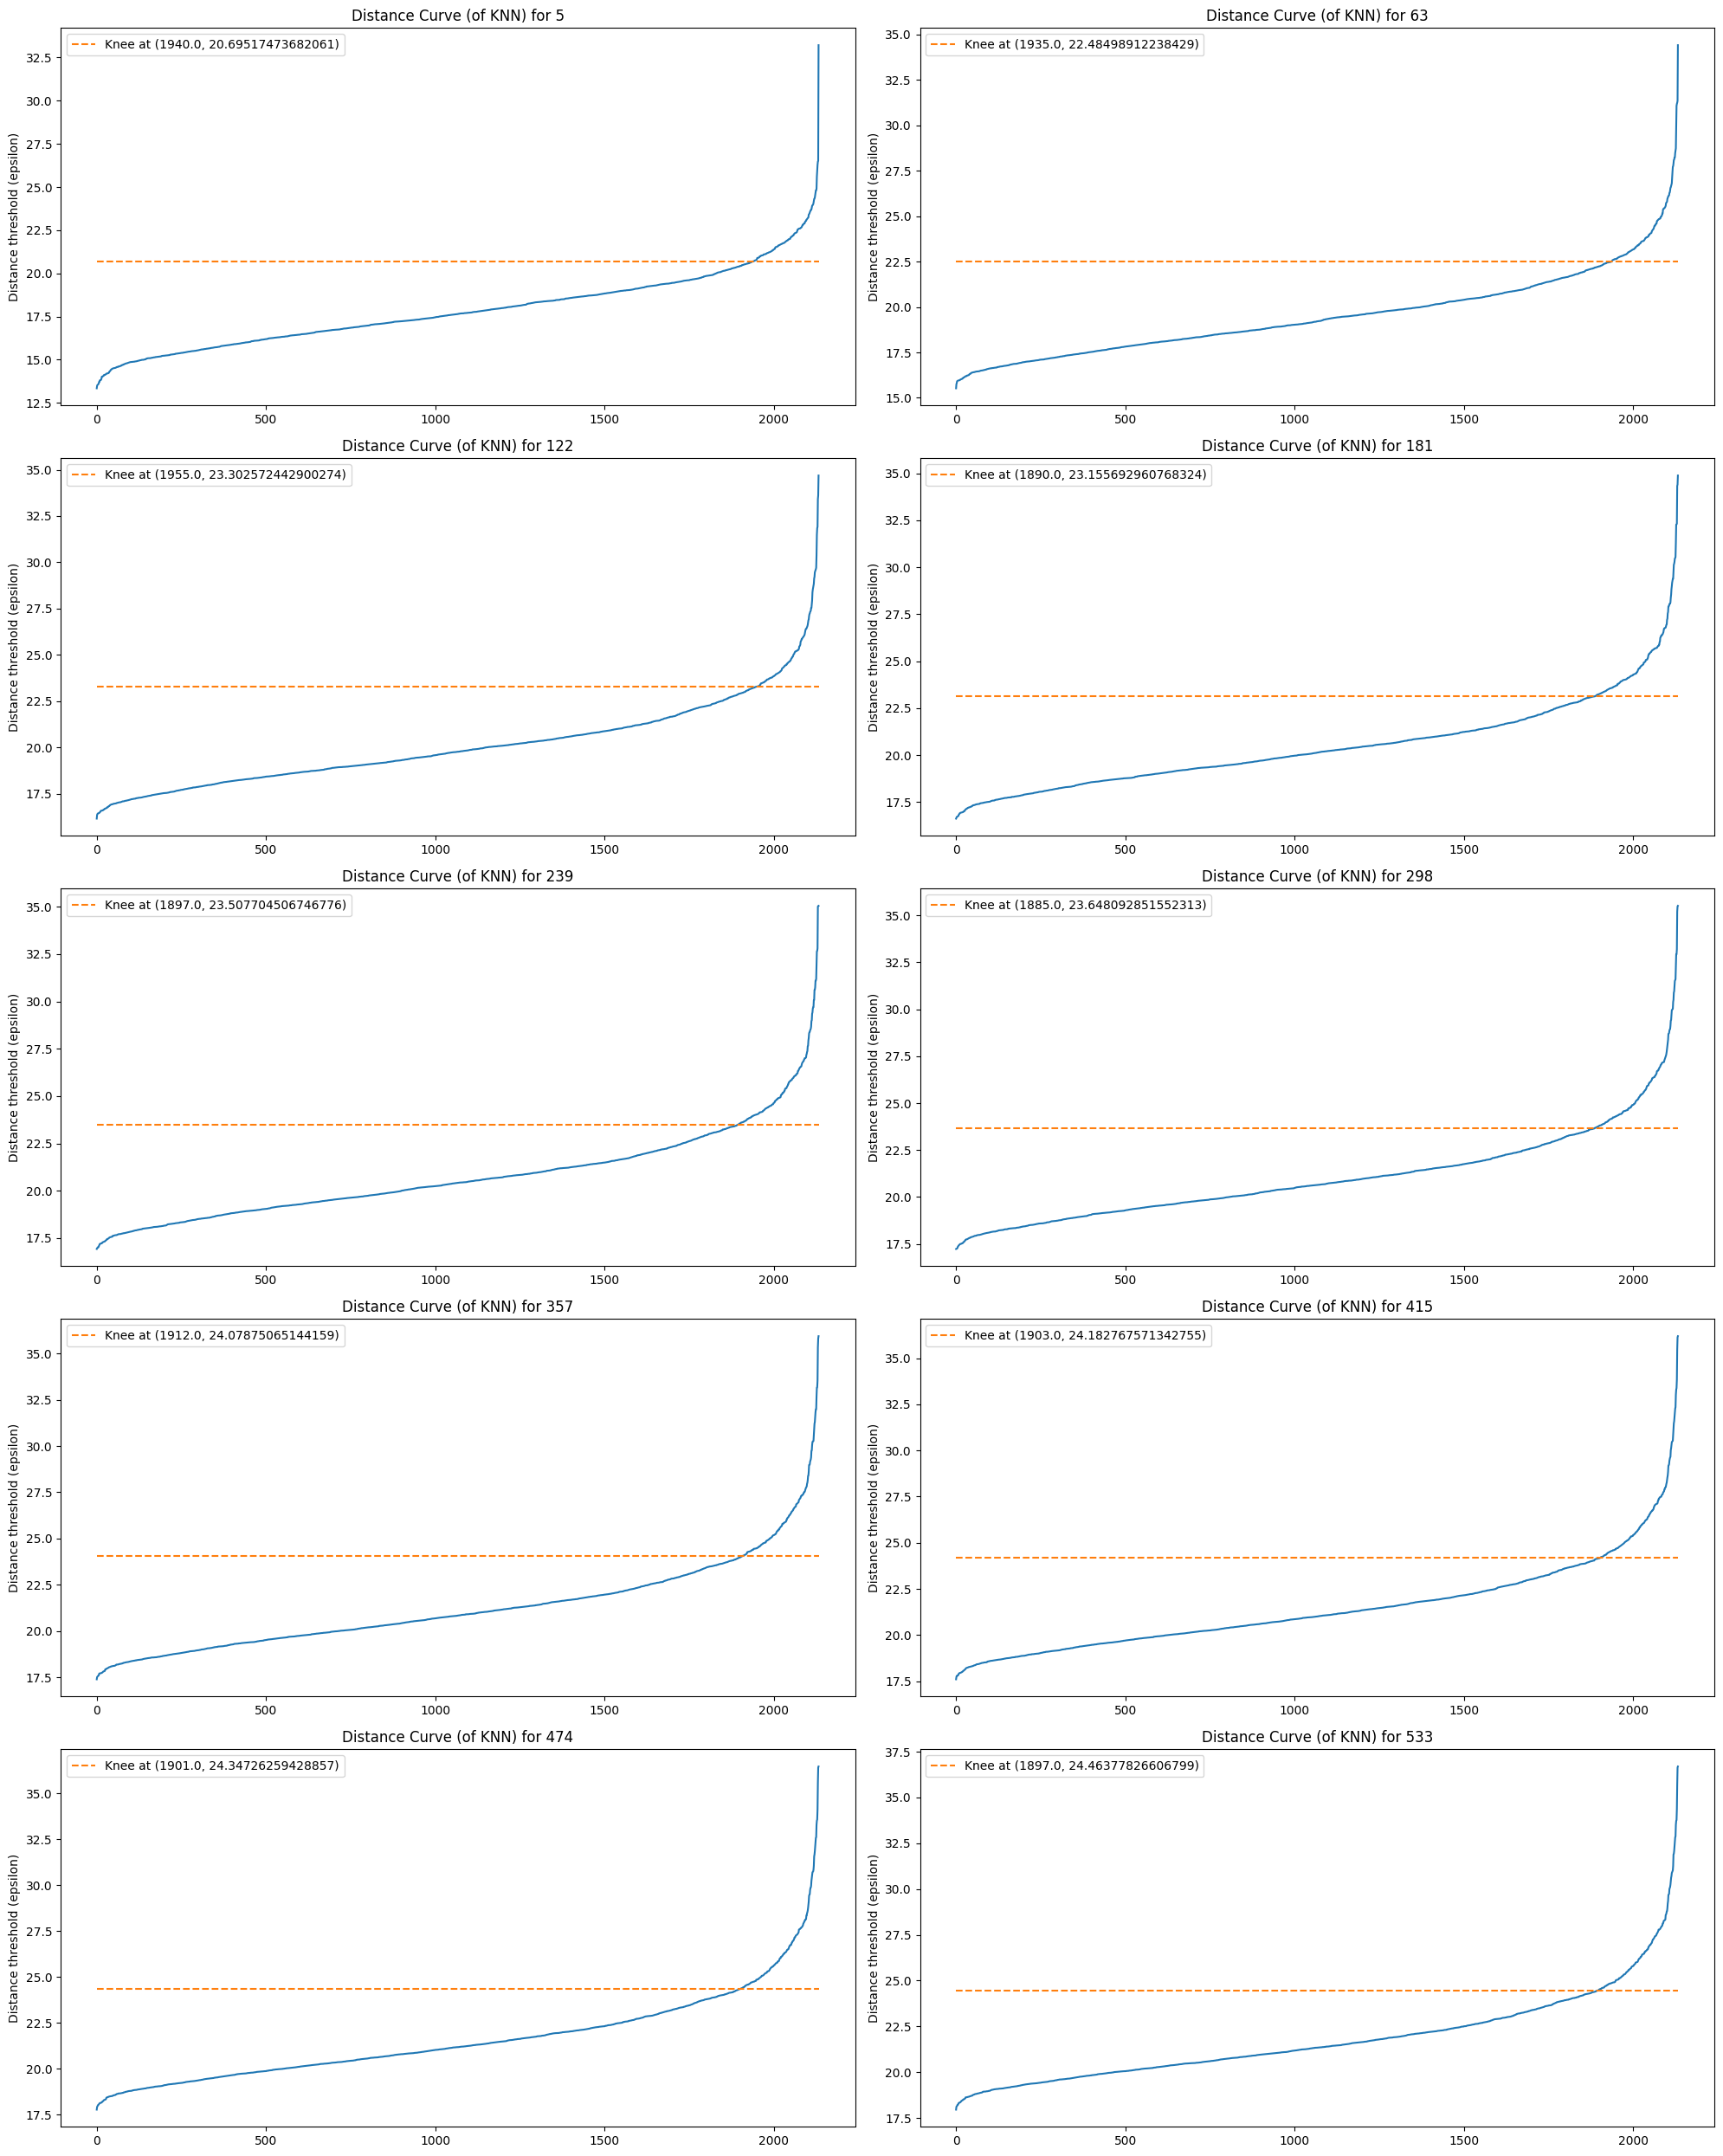

In [38]:
found_eps_values = []
ncols = 2
nrows = int(np.ceil(len(MIN_SAMPLES_VALUES) / ncols))
fig, axs = plt.subplots(nrows, ncols, figsize=(10*ncols, 5*nrows))
axs = np.ravel(axs)
for min_samples, ax in zip(MIN_SAMPLES_VALUES, axs):
    found_eps_values.append(tune_dbscan(data, min_samples, ax))
fig.tight_layout()
fig.show()

In [39]:
EPS_VALUES = found_eps_values
display(Markdown(f"\n```python\nEPS_VALUES = {pformat(list(EPS_VALUES))}\n```"))


```python
EPS_VALUES = [20.69517473682061,
 22.48498912238429,
 23.302572442900274,
 23.155692960768324,
 23.507704506746776,
 23.648092851552313,
 24.07875065144159,
 24.182767571342755,
 24.34726259428857,
 24.46377826606799]
```

## OPTICS
This method is used as an improvement of DBSCAN (`cluster_method="dbscan"`), therefore only `min_samples` parameter needs to be provided and it can be copied from the values estimated for DBSCAN.

## Gaussian Mixtures
Parameters to evaluate:
* `n_components` - number of mixture components (It will be copied from $k$ value established for KMeans)

## SOM
Paramters to evaluate:
* `n_rows` / `n_cols` - number of neurons in the row / col of som grid (2D map is used). It will be copied from KMeans $k$ value, but with additional `1` value, so there could be a map which is 1D as well.
* `initialcodebook` & `neighborhood` - values available in the library will be used